## Fitting a model to data


This notebook draws heavily from the emcee tutorial: https://emcee.readthedocs.io/en/stable/tutorials/line/.
For further details refer to: Hogg, Bovy, Lang, https://arxiv.org/abs/1008.4686.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import emcee
import corner

Let's first generate some synthetic dataset.

In [2]:
np.random.seed(42) # for reproducibility, we fix the seed of the RNG

atrue = -1.
btrue = 4.0
ftrue = 0.5

# Generate some synthetic data from the model.
n = 50
x = np.sort(10 * np.random.rand(n))
yerr = 0.1 + 0.5 * np.random.rand(n)
y = atrue * x + btrue
y += np.abs(ftrue * y) * np.random.randn(n)
y += yerr * np.random.randn(n)


This synthetic dataset is our "true" model.
We can plot the fake data we generated, together with the true model (straight line)!

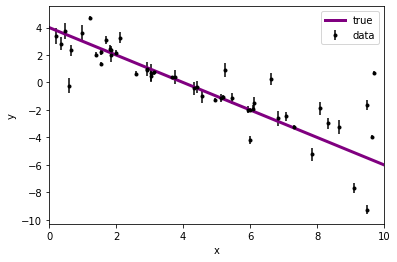

In [3]:
x0 = np.linspace(0, 10, 501, endpoint = True)
plt.errorbar(x, y, yerr = yerr, fmt = '.k', label = 'data')
plt.plot(x0, atrue * x0 + btrue, lw = 3, color = 'purple', label = 'true')
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

We can fit the data using a simple least square method and compare with the line representing the true model.

Least-squares estimates:
a = -0.732 ± 0.012
b = 3.125 ± 0.063


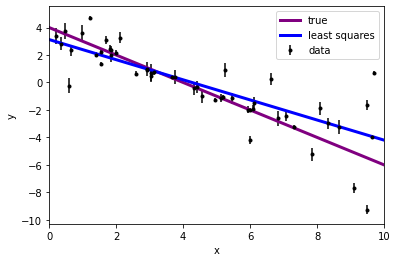

In [4]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("a = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr = yerr, fmt = '.k', label = 'data')
plt.plot(x0, atrue * x0 + btrue, lw = 3, color = 'purple', label = 'true')
plt.plot(x0, np.dot(np.vander(x0, 2), w), lw = 3, color = 'blue', label = 'least squares')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

The fit seems okay, but the vaues of a and b are not exactly what we expected (a=-1, b=4). 
It is reasonable to hypothesise that the reason for the discrepancy might be related to the error treatment.

Let us now try another approach. We will write a maximum likelihood function and try to optimise it.

$$
    \ln\,p(y\,|\,x,\sigma,a,b,f) =
    -\frac{1}{2} \sum_i \left[
        \frac{(y_i-a\,x_i-b)^2}{s_i^2}
        + \ln \left ( 2\pi\,s_i^2 \right )
    \right],
$$

where

$$
    s_i^2 = \sigma_i^2+f^2\,(a\,x_i+b)^2 \quad .
$$

Note that here the variance of the gaussian varies by $f$. 

We can now write down the likelihood function. Note that we will use the logarithm of likelihood function, instead of the function itself. This does make some sense, since $f$ is now always positive.


In [5]:
def lnLikelihood(theta, x, y, yerr):
    a, b, log_f = theta
    model = a * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2. * log_f)
    return - 0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

We can optimise this function using SciPy's built-in functions.

Maximum likelihood estimates:
a = -0.901
b = 3.566
f = 0.508


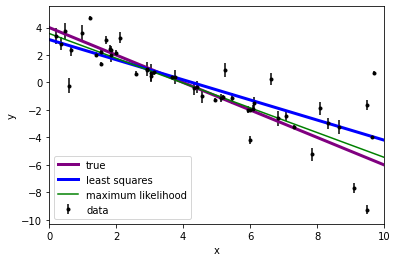

In [6]:
np.random.seed(42)
nll = lambda *args: -lnLikelihood(*args)
initial = np.array([atrue, btrue, np.log(ftrue)]) + 0.1 * np.random.randn(3)
soln = scipy.optimize.minimize(nll, initial, args = (x, y, yerr))
aml, bml, logfml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(aml))
print("b = {0:.3f}".format(bml))
print("f = {0:.3f}".format(np.exp(logfml)))


plt.errorbar(x, y, yerr = yerr, fmt = '.k',  label = 'data')
plt.plot(x0, atrue * x0 + btrue, lw = 3, color = 'purple', label = 'true')
plt.plot(x0, np.dot(np.vander(x0, 2), w), lw = 3, color = 'blue', label = 'least squares')
plt.plot(x0, np.dot(np.vander(x0, 2), [aml, bml]), "green", label = 'maximum likelihood')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


This method is clearly better than the simple least-square estimate. 
Now we have to try to estimate the fit uncertainties. To this end, we will employ MCMC.

Intuitively, we have some idea of the interval wherein the parameters $a$ and $b$ lie, although it is not clear if there is a preferred value within this range. Therefore, we assume a uniform distribution for $a \in [-5, 5]$ and $b \in [0, 10]$. This will be the prior we input in the code.

In [7]:
def logPrior(theta):
    a, b, logf = theta
    if -5.0 < a < 0.5 and 0.0 < b < 10.0 and -10.0 < logf < 1.0:
        return 0.0
    return -np.inf

In [8]:
def logProbability(theta, x, y, yerr):
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnLikelihood(theta, x, y, yerr)

Now we can setup our MCMC. We select the walkers in regions where the likelihood is maximum, according to a gaussian distribution.

In [14]:
ndim = 3
nwalkers = 50
niterations = 10000
pos = soln.x + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args = (x, y, yerr))
sampler.run_mcmc(pos, niterations, progress = True)

100%|██████████| 10000/10000 [00:20<00:00, 495.31it/s]


State([[-0.92750522  3.74335056 -0.54010956]
 [-0.93255317  3.59404218 -0.66345305]
 [-0.99923532  4.06079771 -0.61226662]
 [-0.82986946  3.21159918 -0.69260482]
 [-0.93448651  3.5375563  -0.44254145]
 [-1.04768116  3.96276282 -0.80082734]
 [-0.85968309  3.47043746 -0.50810015]
 [-0.88419918  3.5067359  -0.68823868]
 [-1.13384826  4.43643136 -0.76316437]
 [-0.87473798  3.37283167 -0.62243104]
 [-0.86007762  3.50401578 -0.5739694 ]
 [-0.76041201  2.98281366 -0.23222689]
 [-0.85252037  3.4814853  -0.62271232]
 [-0.84064635  3.31856707 -0.71211682]
 [-0.7437296   2.97649828 -0.39635489]
 [-0.93843378  3.87524745 -0.75392088]
 [-0.95339169  3.79144264 -0.65596293]
 [-1.11402258  4.1670538  -0.71856452]
 [-1.00314556  3.97009904 -0.75159833]
 [-0.88889847  3.47031331 -0.65507195]
 [-0.97364834  3.78601265 -0.97501898]
 [-0.90833     3.62919872 -0.69038223]
 [-0.98223906  3.84185946 -0.74115504]
 [-0.90493549  3.6654019  -0.64224901]
 [-0.88879097  3.57600382 -0.64459088]
 [-0.9465245   3.67

Let's take a look at what the sampler has done. First, the time series can be plotted. (The colours correspond to different walkers).

Text(0.5, 0, 'step number')

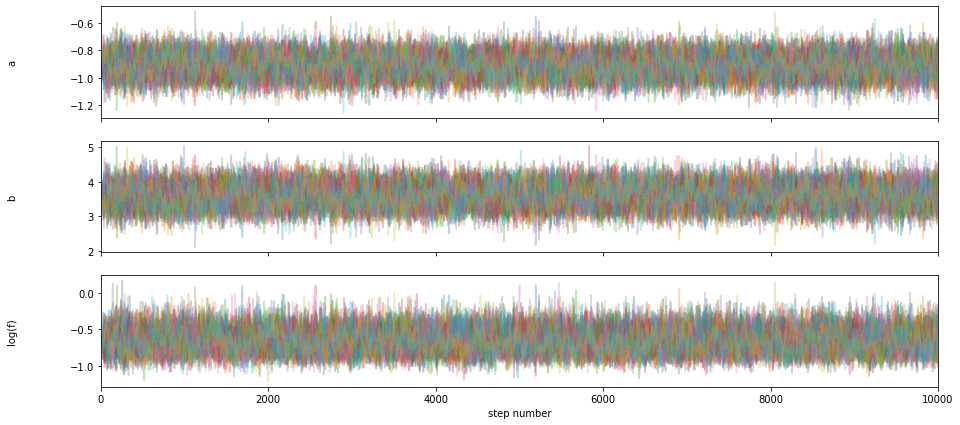

In [15]:
fig, axes = plt.subplots(3, figsize = (15, 7), sharex = True)
samples = sampler.get_chain()
labels = ['a', 'b', 'log(f)']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

Recall that the walkers started around the position in the parameter space of maximum likelihood. They wondered around with probabilities according to the distribution we inputed.

An autocorrelation analysis can give us a hint about how long it takes for the walkers to start converging. This can be easily obtained using the function below.

In [16]:
tau = sampler.get_autocorr_time()
print(tau)

[38.79405452 38.79872705 35.99030185]


So the walkers "lose their memory" after 40 iterations, approximately. To avoid having our results "contaminated" by walkers with correlations between adjacent positions, we throw away the first few iteration. 50 would be enough, but let's throw away 100. We say that they were "burned".

Let's throw away the burned steps, and randomly select 10% of the total samples.

Finally, we can make a plot of $a$ and $b$ including an improved error estimate.

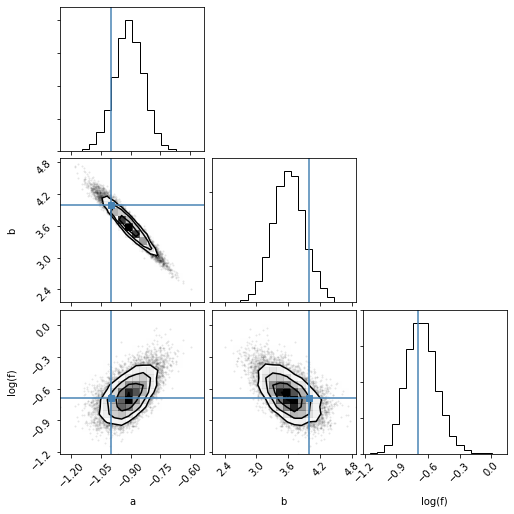

In [18]:
flatSamples = sampler.get_chain(discard = 100, thin = 50, flat = True)

corner.corner(flatSamples, labels = labels, truths = [atrue, btrue, np.log(ftrue)]);

We can clearly see the correlations and the posterior distributions. 

We can now plot a few samples over the points

The last step is to determine what the parameters $a$ and $b$ are, including the uncertainties.

The corner plot shows all the one and two dimensional projections of the
posterior probability distributions of your parameters.
This is useful because it quickly demonstrates all of the covariances between
parameters.
Also, the way that you find the marginalized distribution for a parameter or
set of parameters using the results of the MCMC chain is to project the
samples into that plane and then make an N-dimensional histogram.
That means that the corner plot shows the marginalized distribution for each
parameter independently in the histograms along the diagonal and then the
marginalized two dimensional distributions in the other panels.

Another diagnostic plot is the projection of your results into the space of
the observed data.
To do this, you can choose a few (say 100 in this case) samples from the chain
and plot them on top of the data points:

value a: -0.910  +0.073 -0.072
value b: 3.612  +0.296 -0.292
value log(f): -0.664  +0.137 -0.148


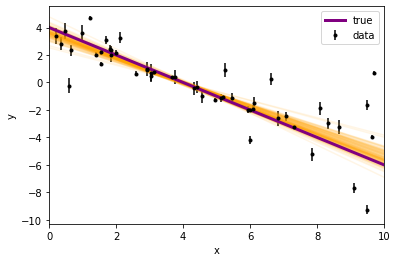

In [19]:
for i in range(ndim):
    mcmc = np.percentile(flatSamples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print('value %s: %4.3f  +%4.3f -%4.3f' % (labels[i], mcmc[1], q[0], q[1]))


idxs = np.random.randint(len(flatSamples), size = 100) # selecting 100 samples
for idx in idxs:
    sample = flatSamples[idx]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), 'orange', alpha = 0.1)
plt.errorbar(x, y, yerr = yerr, fmt = '.k', label = 'data')
plt.plot(x0, atrue * x0 + btrue, lw = 3, color = 'purple', label = 'true')
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()